### Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import pandas as pd

In [3]:
#A ne pas executer si déjà téléchargés
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

### Test avec fetch20newsgroup

In [4]:
'''from sklearn.datasets import fetch_20newsgroups
X_train, y_train = fetch_20newsgroups(subset='train', return_X_y=True)
X_test, y_test = fetch_20newsgroups(subset='test', return_X_y=True)
X_train'''

"from sklearn.datasets import fetch_20newsgroups\nX_train, y_train = fetch_20newsgroups(subset='train', return_X_y=True)\nX_test, y_test = fetch_20newsgroups(subset='test', return_X_y=True)\nX_train"

In [5]:
#X_train[0]

### Test, traitement, récupération des traces

In [6]:
data_1 = pd.read_json('Data\messages_chat_seance1\exportChatMessage\\0dfd43cb-9957-4102-954a-899ca075e56d.json')
data_2 = pd.read_json('Data\messages_chat_seance1\exportChatMessage\\1db9dee2-2702-457f-aa07-6b60589446ce.json')
data_3 = pd.read_json('Data\messages_chat_seance1\exportChatMessage\\2ccf746f-62b9-4690-8bff-59c49fb2c310.json')

Recupérer ici la fin du fichier : seance 1 ne regroupe que 3 messages :: mettre dans seance 1 tous les messages de la seance 1
creer csv avec toutes les données : seance + nomfichier comme id.

In [7]:
# Gros df avec les 3 données
messages_df = pd.concat([data_1,data_2,data_3],axis = 0)
messages_df.reset_index(drop=True, inplace=True) #Créer un id ? Plus tard, quand mesure d'impact -> nécessité de tracer
messages_df.head(5)

,user,role,message,timestamp
0,194872,Driver,roro,2024-10-09 04:24:09.074000+00:00
1,194872,Driver,Qui est là,2024-10-09 04:27:03.939000+00:00
2,145797,Driver,Bonjour,2024-10-09 04:22:52.924000+00:00
3,200807,Navigator,Bonjour,2024-10-09 04:24:14.448000+00:00
4,145797,Driver,tu pense si je fais un for in in range avec un...,2024-10-09 04:25:31.692000+00:00


In [58]:
def parse_json_files_in_folder(folder_path):
    """
    Parses all JSON files in a folder and concatenates them into a pandas DataFrame.

    Args:
        folder_path (str): The path to the folder containing the JSON files.

    Returns:
        pandas.DataFrame: A DataFrame containing the concatenated data from all JSON files.
    """
    all_data = []
    groupid = 0 #find a way to add group id
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            filepath = os.path.join(folder_path, filename)
            with open(filepath, 'r') as f:
                data = json.load(f)
                print(data)
                all_data.extend(data)  # Assuming each JSON file contains a list of dictionaries

    return pd.DataFrame(all_data)

In [59]:
seance1_df = parse_json_files_in_folder('Data\messages_chat_seance1\exportChatMessage')

[{'user': '186202', 'role': 'Navigator', 'message': 'Tu es qui ,', 'timestamp': '2024-10-09T04:38:10.418Z'}, {'user': '186202', 'role': 'Navigator', 'message': 'On se met 5 partout ok ?', 'timestamp': '2024-10-09T04:38:23.761Z'}]
[{'user': '183897', 'role': 'Driver', 'message': 'Opé', 'timestamp': '2024-10-09T04:21:22.214Z'}, {'user': '183897', 'role': 'Driver', 'message': 'Opé lmkt', 'timestamp': '2024-10-09T04:21:39.982Z'}, {'user': '193392', 'role': 'Navigator', 'message': 'A PAR SA LE COUZ ', 'timestamp': '2024-10-09T04:21:46.552Z'}, {'user': '183897', 'role': 'Driver', 'message': 'Opé ', 'timestamp': '2024-10-09T04:25:11.271Z'}, {'user': '183897', 'role': 'Driver', 'message': 'Ou lé jolie ? ', 'timestamp': '2024-10-09T04:26:09.319Z'}, {'user': '183897', 'role': 'Driver', 'message': 'A ou ', 'timestamp': '2024-10-09T04:26:41.181Z'}, {'user': '183897', 'role': 'Driver', 'message': 'Commencé ', 'timestamp': '2024-10-09T04:26:43.332Z'}, {'user': '183897', 'role': 'Driver', 'message': 

In [9]:
seance1_df = parse_json_files_in_folder('Data\messages_chat_seance1\exportChatMessage')
print("seance1_df shape : ",seance1_df.shape)
seance1_df['message'].values

seance1_df shape :  (440, 4)


array(['Tu es qui ,', 'On se met 5 partout ok ?', 'Opé', 'Opé lmkt',
       'A PAR SA LE COUZ ', 'Opé ', 'Ou lé jolie ? ', 'A ou ',
       'Commencé ', 'Comment nous fé la ', "c'est kwé faut fait ",
       'Lève ton main un coup la ', 'aide a moins un coup la ', 'roro',
       'Qui est là', 'je ne sais pas comment voir le résultat ',
       'faut mettre print(coincide)', 'essaye', 'attend',
       "je crois que c'est bon", 'Bonjour', 'Bonjour',
       'tu pense si je fais un for in in range avec un for j in range dedans ça peut marcher? ',
       'oui ', 'tu veux editer?', 'comme tu veux',
       'je teste si ça marche pas on echange', 'vsy ',
       'en vrai c\'est pas mieux de faire un "if len(a) != len(b)"',
       'tu veux teste?', "demande l'édition", 'vsy je teste le code',
       "quand je teste le code il me disent y'a des erreurs de type",
       'pour int', 'je sais pas pk',
       'demande a éditer je te passe la main tu teste ce que tu as dis',
       "vsy je sauvegarde jus

In [10]:
seance1_msg = seance1_df['message'].values #Récupère les valeurs de la colonne message et en fait une liste
print(len(seance1_msg))
print(seance1_msg)

440
['Tu es qui ,' 'On se met 5 partout ok ?' 'Opé' 'Opé lmkt'
 'A PAR SA LE COUZ ' 'Opé ' 'Ou lé jolie ? ' 'A ou ' 'Commencé '
 'Comment nous fé la ' "c'est kwé faut fait " 'Lève ton main un coup la '
 'aide a moins un coup la ' 'roro' 'Qui est là'
 'je ne sais pas comment voir le résultat ' 'faut mettre print(coincide)'
 'essaye' 'attend' "je crois que c'est bon" 'Bonjour' 'Bonjour'
 'tu pense si je fais un for in in range avec un for j in range dedans ça peut marcher? '
 'oui ' 'tu veux editer?' 'comme tu veux'
 'je teste si ça marche pas on echange' 'vsy '
 'en vrai c\'est pas mieux de faire un "if len(a) != len(b)"'
 'tu veux teste?' "demande l'édition" 'vsy je teste le code'
 "quand je teste le code il me disent y'a des erreurs de type" 'pour int'
 'je sais pas pk'
 'demande a éditer je te passe la main tu teste ce que tu as dis'
 "vsy je sauvegarde juste le ocde que t'a déja fait" 'ok' 'je supprime'
 "c bon t'as la main" "je crois c'est bon , je suis pas sur"
 'tu peux tester?'


In [11]:
seance2_df = parse_json_files_in_folder('Data\messages_chat_seance2\exportChatMessage')
print("seance2_df shape : ",seance2_df.shape)
seance2_df['message'].values

seance2_df shape :  (1315, 4)


array(['bonjour ', 'bonjour', 'tu es bloqué?', ...,
       'Tu voulais tous les mettre total non ?',
       'Sais-tu pourquoi il y a une erreur ?', "c'est bon"], dtype=object)

In [12]:
seance2_msg = seance2_df['message'].values #Récupère les valeurs de la colonne message et en fait une liste
print(len(seance2_msg))
print(seance2_msg)

1315
['bonjour ' 'bonjour' 'tu es bloqué?' ...
 'Tu voulais tous les mettre total non ?'
 'Sais-tu pourquoi il y a une erreur ?' "c'est bon"]


In [30]:
#Ajout d'une séance colonne pour différencier
seance1_df['seanceID'] = 1
seance1_df.head(5)

,user,role,message,timestamp,Seance
0,186202,Navigator,"Tu es qui ,",2024-10-09T04:38:10.418Z,1
1,186202,Navigator,On se met 5 partout ok ?,2024-10-09T04:38:23.761Z,1
2,183897,Driver,Opé,2024-10-09T04:21:22.214Z,1
3,183897,Driver,Opé lmkt,2024-10-09T04:21:39.982Z,1
4,193392,Navigator,A PAR SA LE COUZ,2024-10-09T04:21:46.552Z,1


In [32]:
seance2_df['seanceID'] = 2
seance2_df.head(5)

,user,role,message,timestamp,Seance
0,183337,Driver,bonjour,2024-11-12T04:30:24.331Z,2
1,145133,Navigator,bonjour,2024-11-12T04:30:44.161Z,2
2,145133,Navigator,tu es bloqué?,2024-11-12T04:36:03.105Z,2
3,145133,Navigator,hésite pas si t'as une idée,2024-11-12T04:39:50.494Z,2
4,183337,Driver,ok,2024-11-12T04:40:06.334Z,2


In [56]:
all_messages_df = pd.concat([seance1_df,seance2_df],axis = 0)
all_messages_df.index.names=['messageID']
print(all_messages_df.head(5),all_messages_df.tail(5))

             user       role                   message  \
messageID                                                
0          186202  Navigator               Tu es qui ,   
1          186202  Navigator  On se met 5 partout ok ?   
2          183897     Driver                       Opé   
3          183897     Driver                  Opé lmkt   
4          193392  Navigator         A PAR SA LE COUZ    

                          timestamp  Seance  
messageID                                    
0          2024-10-09T04:38:10.418Z       1  
1          2024-10-09T04:38:23.761Z       1  
2          2024-10-09T04:21:22.214Z       1  
3          2024-10-09T04:21:39.982Z       1  
4          2024-10-09T04:21:46.552Z       1                user       role                                 message  \
messageID                                                              
1310       144245  Navigator                               c'est bon   
1311       192807     Driver     A la base, ce n'est pa

In [57]:
all_messages_df.to_csv('all_messages.csv')

### Truncated SVD -- LSA (Latent Semantic Analysis)

In [13]:
tokenizer = RegexpTokenizer(r'\b\w{3,}\b') #garde les mots d'au moins trois lettres, avec dans les mots soit des lettres, soit des chiffres (pas de caractères spéciaux)
stop_words = list(set(stopwords.words("french"))) #On enlève les mots communs sans interêt en français ; on garde ceux en anglais car indique probablement du code
print(stop_words)
stop_words += list(string.punctuation)

['ces', 'eusses', 'aurions', 'fussiez', 'dans', 'eues', 'on', 'eue', 'aurez', 'ton', 'eussiez', 'avait', 'serai', 'fûmes', 'ayante', 'aux', 'étaient', 'furent', 'avais', 'un', 'ou', 'eussent', 'fut', 'eurent', 'il', 'aurait', 'mes', 'qu', 'par', 'toi', 'me', 'fût', 'eux', 'avons', 'seriez', 'suis', 'ma', 'aies', 'étant', 'au', 'ce', 'du', 'eut', 'se', 'des', 'eu', 'eûtes', 'en', 'ils', 'aurons', 'votre', 'vous', 'seras', 'sur', 'étions', 'auriez', 'que', 'aient', 'nous', 'aviez', 'je', 'c', 'aura', 'le', 'ayez', 'es', 'serait', 'avions', 'l', 'as', 'étais', 'ta', 'notre', 'étée', 'serais', 'te', 'mais', 'serez', 'y', 'son', 'tes', 'à', 'était', 'serons', 'qui', 'soit', 'avec', 'étées', 'avaient', 's', 'eusse', 'fûtes', 't', 'aurais', 'êtes', 'fusse', 'soient', 'de', 'eus', 'étantes', 'fussions', 'avez', 'étante', 'ses', 'et', 'fus', 'auras', 'été', 'serions', 'soyons', 'ayants', 'eussions', 'ait', 'mon', 'la', 'fusses', 'nos', 'sa', 'fussent', 'auraient', 'moi', 'eûmes', 'est', 'ayant'

In [14]:
#tf-idf = Term Frequency Inverse Document Frequency of records
#tf = term frequency
#idf = inverse codument frequency (les mots les plus communs dans les documents semblent moins significatifs)
tfidf = TfidfVectorizer(lowercase=True, #Convertir tous les caractères en lowercase avant de tokenize
                        stop_words=stop_words,
                        tokenizer=tokenizer.tokenize,
                        max_df=0.7, #ignore les items ayant une fréquence supérieure à x
                        min_df=0.015 #ignore les items ayant une fréquence inférieure à x
                       )

tfidf_train_sparse = tfidf.fit_transform(seance1_msg) # equivalent à fit puis transform : fit entraine le modèle, transform applique le modele sur le dataset
#Crée un DF avec les résultats
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), #transforme une matrice en tableau 2D
                        columns=tfidf.get_feature_names_out()) #get output feature names for transfomation = les mots // les noms des colonnes ?

print('Shape :',tfidf_train_df.shape)
tfidf_train_df.head(2)

Shape : (440, 20)


c:\Users\cbd65\anaconda3\envs\jupyterenv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,activité,bah,bon,comment,faire,fais,fait,faut,fini,main,non,ouais,oui,peux,quoi,sais,salut,tableau,veux,vois
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#Transforme la matrice du dessus en une autre plus réduite en utilisant la décomposition en valeurs singulières A = U * Sigma * V_T.

#n_components = dimension de l'output (100 recommendé pour LSA, doit être <= au nombre de features)
lsa_obj = TruncatedSVD(n_components=20, n_iter=100, random_state=42)
tfidf_lsa_data = lsa_obj.fit_transform(tfidf_train_df)
Sigma = lsa_obj.singular_values_ # Matrice centrale, valeurs correcspondant à chaque composant sélectionné
V_T = lsa_obj.components_.T # components_ = vecteurs singuliers de droite de l'input data
print("V_T shape : ",V_T.shape)

V_T shape :  (20, 20)


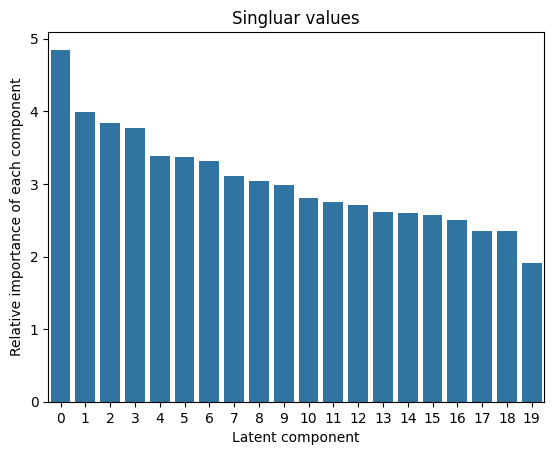

In [16]:
#Affichage de l'importance de chaque composante
axis_object = sns.barplot(x=list(range(len(Sigma))), y = Sigma)
plt.xlabel("Latent component")
plt.ylabel('Relative importance of each component')
plt.title("Singluar values")
plt.show(axis_object)

In [17]:
#Transformation de V_T en DF pour une utilisation plus facile
term_topic_matrix = pd.DataFrame(data=V_T,
                                 index = tfidf_train_df.columns,
                                 columns = [f'Latent_concept_{r}' for r in range(0,V_T.shape[1])])
term_topic_matrix.head(3)

,Latent_concept_0,Latent_concept_1,Latent_concept_2,Latent_concept_3,Latent_concept_4,Latent_concept_5,Latent_concept_6,Latent_concept_7,Latent_concept_8,Latent_concept_9,Latent_concept_10,Latent_concept_11,Latent_concept_12,Latent_concept_13,Latent_concept_14,Latent_concept_15,Latent_concept_16,Latent_concept_17,Latent_concept_18,Latent_concept_19
activité,0.000565,0.005773,-0.001997,0.004971,0.007559,0.001825,0.034355,-0.018979,-0.026452,0.157994,0.072556,0.456579,0.253099,-0.108628,-0.009893,0.110679,0.003384,-0.008375,0.021835,0.818645
bah,0.044633,-0.002315,0.002000,-0.007283,0.006878,0.068611,0.082061,-0.023649,-0.019650,-0.007937,-0.000312,-0.030747,-0.002718,0.004739,0.007485,-0.013426,0.002054,-0.171344,0.977119,-0.010550
bon,0.993513,-0.079948,0.017527,-0.025439,0.017438,-0.028047,0.005579,0.019879,-0.010384,-0.023795,-0.029910,0.010543,0.013555,0.010638,0.001181,-0.006782,0.010668,0.001289,-0.043924,0.000524


In [18]:
def visualize_top_bottom_terms_component(matrix,nbComponent):
    name_col = 'Latent_concept_'+str(nbComponent)
    data = matrix[name_col]
    data = data.sort_values(ascending=False)
    top_10 = data[:10]
    data = data.sort_values(ascending=True)
    bottom_10 = data[:10]
    #fig,axes = plt.subplots(nrows=1, ncols=2,figsize=(5,5))

    plt.subplot(1,2,1)
    plt.bar(top_10.values,top_10.index)

    plt.subplot(1,2,2)
    plt.bar(bottom_10.values,bottom_10.index)

    plt.show()


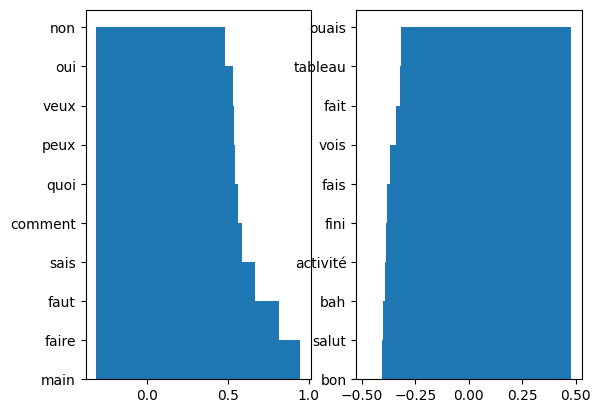

In [19]:
visualize_top_bottom_terms_component(term_topic_matrix,1) ##not working

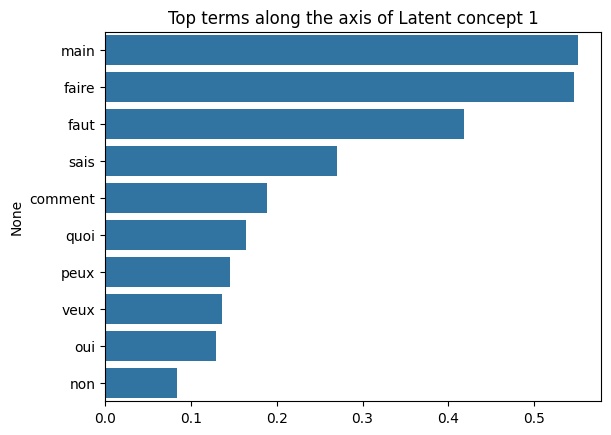

In [20]:
data = term_topic_matrix['Latent_concept_1']
data = data.sort_values(ascending=False)
top_10 = data[:10]
plt.title('Top terms along the axis of Latent concept 1')
fig = sns.barplot(x= top_10.values, y=top_10.index)

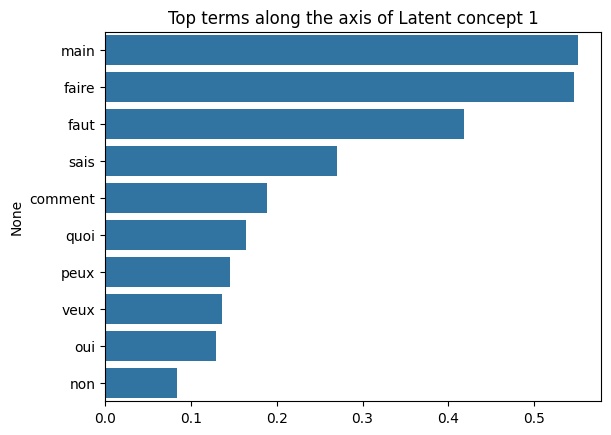

In [21]:
data = term_topic_matrix[f'Latent_concept_1']
data = data.sort_values(ascending=False)
top_10 = data[:10]
plt.title('Top terms along the axis of Latent concept 1')
fig = sns.barplot(x= top_10.values, y=top_10.index)

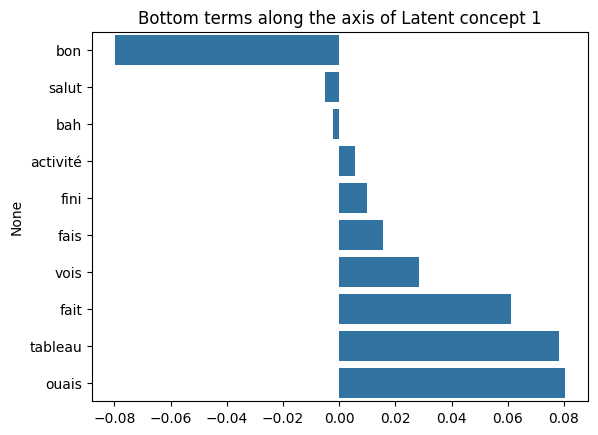

In [22]:
data = term_topic_matrix[f'Latent_concept_1']
data = data.sort_values(ascending=True)
top_10 = data[:10]
plt.title('Bottom terms along the axis of Latent concept 1')
fig = sns.barplot(x= top_10.values, y=top_10.index)

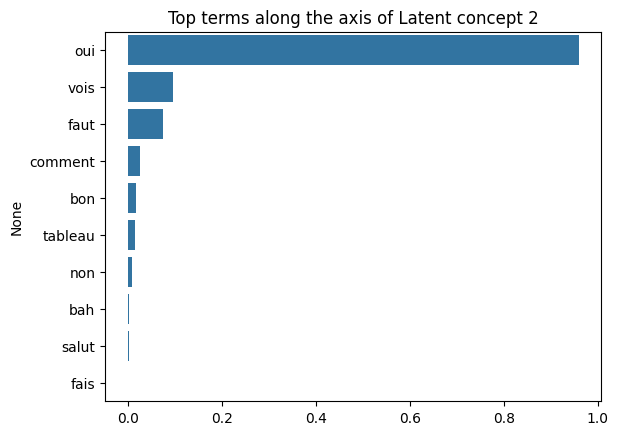

In [23]:
data = term_topic_matrix[f'Latent_concept_2']
data = data.sort_values(ascending=False)
top_10 = data[:10]
plt.title('Top terms along the axis of Latent concept 2')
fig = sns.barplot(x= top_10.values, y=top_10.index)

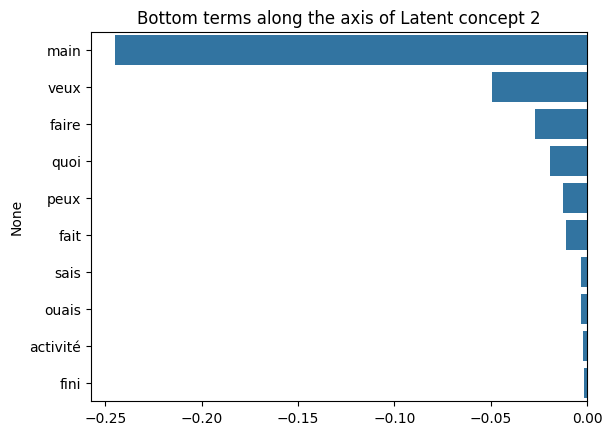

In [24]:
data = term_topic_matrix[f'Latent_concept_2']
data = data.sort_values(ascending=True)
top_10 = data[:10]
plt.title('Bottom terms along the axis of Latent concept 2')
fig = sns.barplot(x= top_10.values, y=top_10.index)

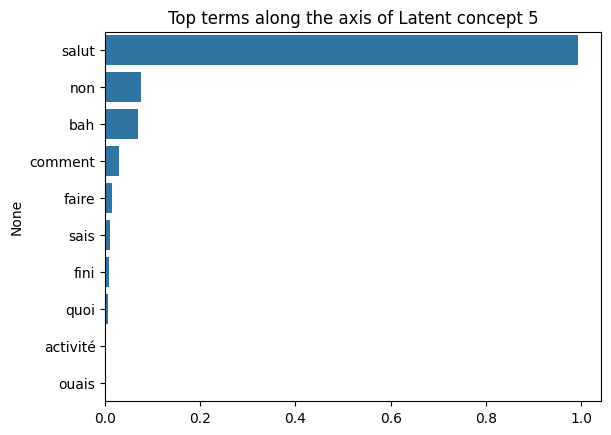

In [25]:
data = term_topic_matrix[f'Latent_concept_5']
data = data.sort_values(ascending=False)
top_10 = data[:10]
plt.title('Top terms along the axis of Latent concept 5')
fig = sns.barplot(x= top_10.values, y=top_10.index)

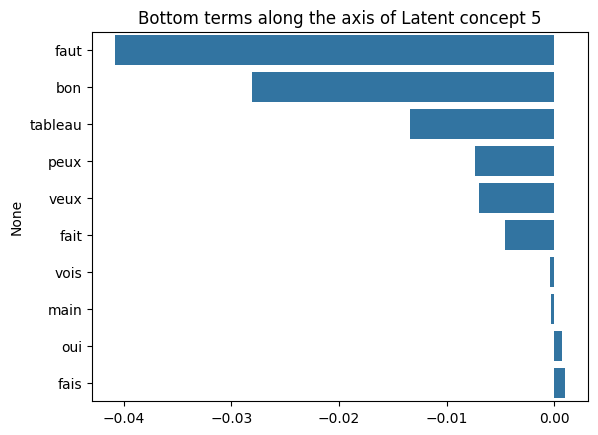

In [26]:
data = term_topic_matrix[f'Latent_concept_5']
data = data.sort_values(ascending=True)
top_10 = data[:10]
plt.title('Bottom terms along the axis of Latent concept 5')
fig = sns.barplot(x= top_10.values, y=top_10.index)